Goal: build a deep neural network with more than 1 hidden layer

In [1]:
# mount google drive. data and utils 
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Coursera/Coursera_DeepLearningSpecialization/course1_coding_assignments/W4A1/

Mounted at /gdrive
/gdrive/My Drive/Coursera/Coursera_DeepLearningSpecialization/course1_coding_assignments/W4A1


In [2]:
!ls

Building_your_Deep_Neural_Network_Step_by_Step.ipynb  public_tests.py
C1WK4_Build_L_Layer_DNN_Step_by_Step.ipynb	      __pycache__
C1WK4_Build_L_Layer_DNN_Step_by_Step_w_Tests.ipynb    testCases.py
dnn_utils.py					      test_utils.py
images


In [3]:
# load packages 
import numpy as np 
import h5py 
import matplotlib.pyplot as plt 
# load utils
from testCases import * 
from dnn_utils import sigmoid, sigmoid_backward, relu, relu_backward 
from public_tests import *

%matplotlib inline 
plt.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

## Initialize parameters of a L layer neural network

In [4]:
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    e.g. [5,4,3]
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims) 

    for l in range(1, L): 
        # note: randn is normal distribution 
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

    return parameters

## Forward Propogation

In [5]:
def linear_forward(A, W, b):
    """
    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns: 
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python tuple containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    Z = np.dot(W, A) + b
    cache = (A, W, b)
    
    return Z, cache

In [6]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR -> ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python tuple containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    Z, linear_cache = linear_forward(A_prev, W, b)
    if activation == "sigmoid":
        A, activation_cache = sigmoid(Z)
    if activation == "relu":
        A, activation_cache = relu(Z)
    cache = (linear_cache, activation_cache)
    return A, cache


In [7]:
def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- activation value from the output (last) layer
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L of them, indexed from 0 to L-1)
    """
    caches = []
    A = X 
    L = len(parameters) // 2 # parameters has W and b two keys for each layer

    for l in range(1, L):
        A_prev = A
        W = parameters['W' + str(l)]
        b = parameters['b' + str(l)]
        activation = 'relu'
        A, cache = linear_activation_forward(A_prev, W, b, activation)
        caches.append(cache)

    # last layer: sigmoid
    W = parameters['W' + str(L)]
    b = parameters['b' + str(L)]
    activation = 'sigmoid'
    AL, cache = linear_activation_forward(A, W, b, activation)
    caches.append(cache)

    return AL, caches


## Cost function
Formula: 
$$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) \tag{7}$$

In [8]:
def compute_cost(AL, Y):
    """
    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    m = Y.shape[1]
    cost = - 1/m * np.sum(np.multiply(Y, np.log(AL)) + np.multiply((1-Y), np.log(1-AL)))
    cost = np.squeeze(cost) # np.squeeze: remove single-dimensional entries from the shape of an array
    return cost

## Backward Propagation

$$ dW^{[l]} = \frac{\partial \mathcal{J} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} \tag{8}$$
$$ db^{[l]} = \frac{\partial \mathcal{J} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}\tag{9}$$
$$ dA^{[l-1]} = \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]} \tag{10}$$

In [9]:
def linear_backward(dZ, cache):
    """
    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = 1/m * dZ.dot(A_prev.T)
    db = 1/m * np.sum(dZ, axis = 1, keepdims = True) # sum across columns, entire row's sum
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db

Linear activation backward

$$dZ^{[l]} = dA^{[l]} * g'(Z^{[l]}). \tag{11}$$  

In [10]:
def linear_activation_backward(dA, cache, activation):
    """
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    if activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
    dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db

## L Model Backward

`dAL` $= \frac{\partial \mathcal{L}}{\partial A^{[L]}}$

$$grads["dW" + str(l)] = dW^{[l]}\tag{15} $$

In [11]:
def L_model_backward(AL, Y, caches):

    grads = {}
    L = len(caches) # number of layers 
    m = AL.shape[1] 
    Y = Y.reshape(AL.shape) # the same shape as AL

    # derivative of cost with respect to AL. 
    # Using calculus to implement the formula above, don't need in-depth knowledge of
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) 

    # get the last layer variables
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, caches[L-1], "sigmoid")
    grads["dA" + str(L-1)] = dA_prev_temp
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp

    # reverse loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA = grads["dA" + str(l + 1)]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dA, current_cache, "relu")
        grads["dA" + str(l)] = dA_prev_temp # start from l = L-2
        grads["dW" + str(l+1)] = dW_temp
        grads["db" + str(l+1)] = db_temp

    return grads


## Update Parameters

$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} \tag{16}$$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} \tag{17}$$

In [12]:
def update_parameters(params, grads, learning_rate):
    """
    Arguments:
    params -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...    
    """

    parameters = params.copy() # need to update params later
    L = len(parameters) // 2 

    for l in range(L): 
        parameters['W' + str(l+1)] = params['W' + str(l+1)] - learning_rate * grads['dW' + str(l+1)]
        parameters['b' + str(l+1)] = params['b' + str(l+1)] - learning_rate * grads['db' + str(l+1)]

    return parameters

## L Layer Model

In [13]:
def L_layer_model(X, Y, layers_dims, 
                  learning_rate = 0.0075, num_iterations = 3000, print_cost = False):
    """
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    np.random.seed(1)
    costs = []

    parameters = initialize_parameters_deep(layers_dims)
    # print('parameters: ', parameters)

    for i in range(0, num_iterations):
        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y)
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)
        # print(f'parameters at iteration {i}: {parameters}')

        if print_cost and i % 100 == 0 or i == num_iterations - 1: 
            print(f'Cost after iteration {i}: {np.squeeze(cost)}')
        if i % 100 == 0 or i == num_iterations: 
            costs.append(cost)
    
    # print('parameters: ', parameters)
    # print('cost: ', cost)
    return parameters, costs

In [14]:
# cd to WK4A2
%cd ../W4A2/
!ls

/gdrive/My Drive/Coursera/Coursera_DeepLearningSpecialization/course1_coding_assignments/W4A2
 datasets				    public_tests.py
'Deep Neural Network - Application.ipynb'   __pycache__
 dnn_app_utils_v3.py			    test_utils_a2.py
 images					    test_utils.py
 public_tests_a2.py


In [15]:
import scipy
from PIL import Image
from scipy import ndimage
del initialize_parameters_deep, compute_cost
from dnn_app_utils_v3 import load_data, predict, print_mislabeled_images, initialize_parameters_deep, compute_cost
# del L_layer_model_test
from public_tests_a2 import L_layer_model_test # same file name in /W4A1
np.random.seed(1)

In [16]:
# load data 
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


In [17]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


## Train the Model

In [20]:
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model

In [21]:
parameters, costs = L_layer_model(train_x, train_y, layers_dims, 
                                  num_iterations = 2500, print_cost = True)

Cost after iteration 0: 0.7717493284237686
Cost after iteration 100: 0.6720534400822914
Cost after iteration 200: 0.6482632048575212
Cost after iteration 300: 0.6115068816101354
Cost after iteration 400: 0.5670473268366111
Cost after iteration 500: 0.5401376634547801
Cost after iteration 600: 0.5279299569455267
Cost after iteration 700: 0.46547737717668514
Cost after iteration 800: 0.36912585249592794
Cost after iteration 900: 0.39174697434805344
Cost after iteration 1000: 0.3151869888600617
Cost after iteration 1100: 0.2726998441789385
Cost after iteration 1200: 0.23741853400268137
Cost after iteration 1300: 0.19960120532208644
Cost after iteration 1400: 0.18926300388463305
Cost after iteration 1500: 0.1611885466582775
Cost after iteration 1600: 0.14821389662363316
Cost after iteration 1700: 0.13777487812972944
Cost after iteration 1800: 0.12974017549190123
Cost after iteration 1900: 0.12122535068005212
Cost after iteration 2000: 0.1138206066863371
Cost after iteration 2100: 0.1078392

In [22]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9856459330143539


In [23]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.8


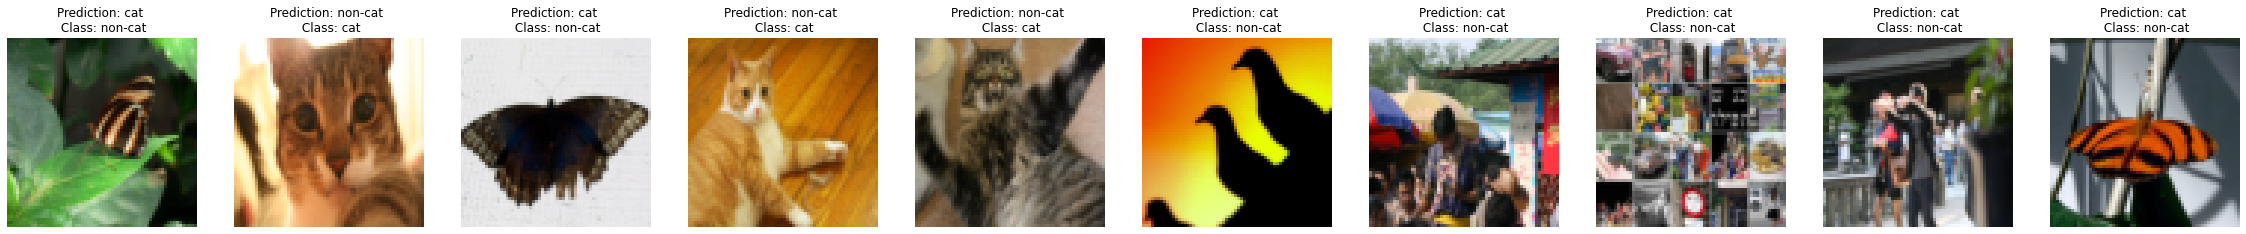

In [24]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

Accuracy: 0.0
y = 0.0, your L-layer model predicts a "non-cat" picture.


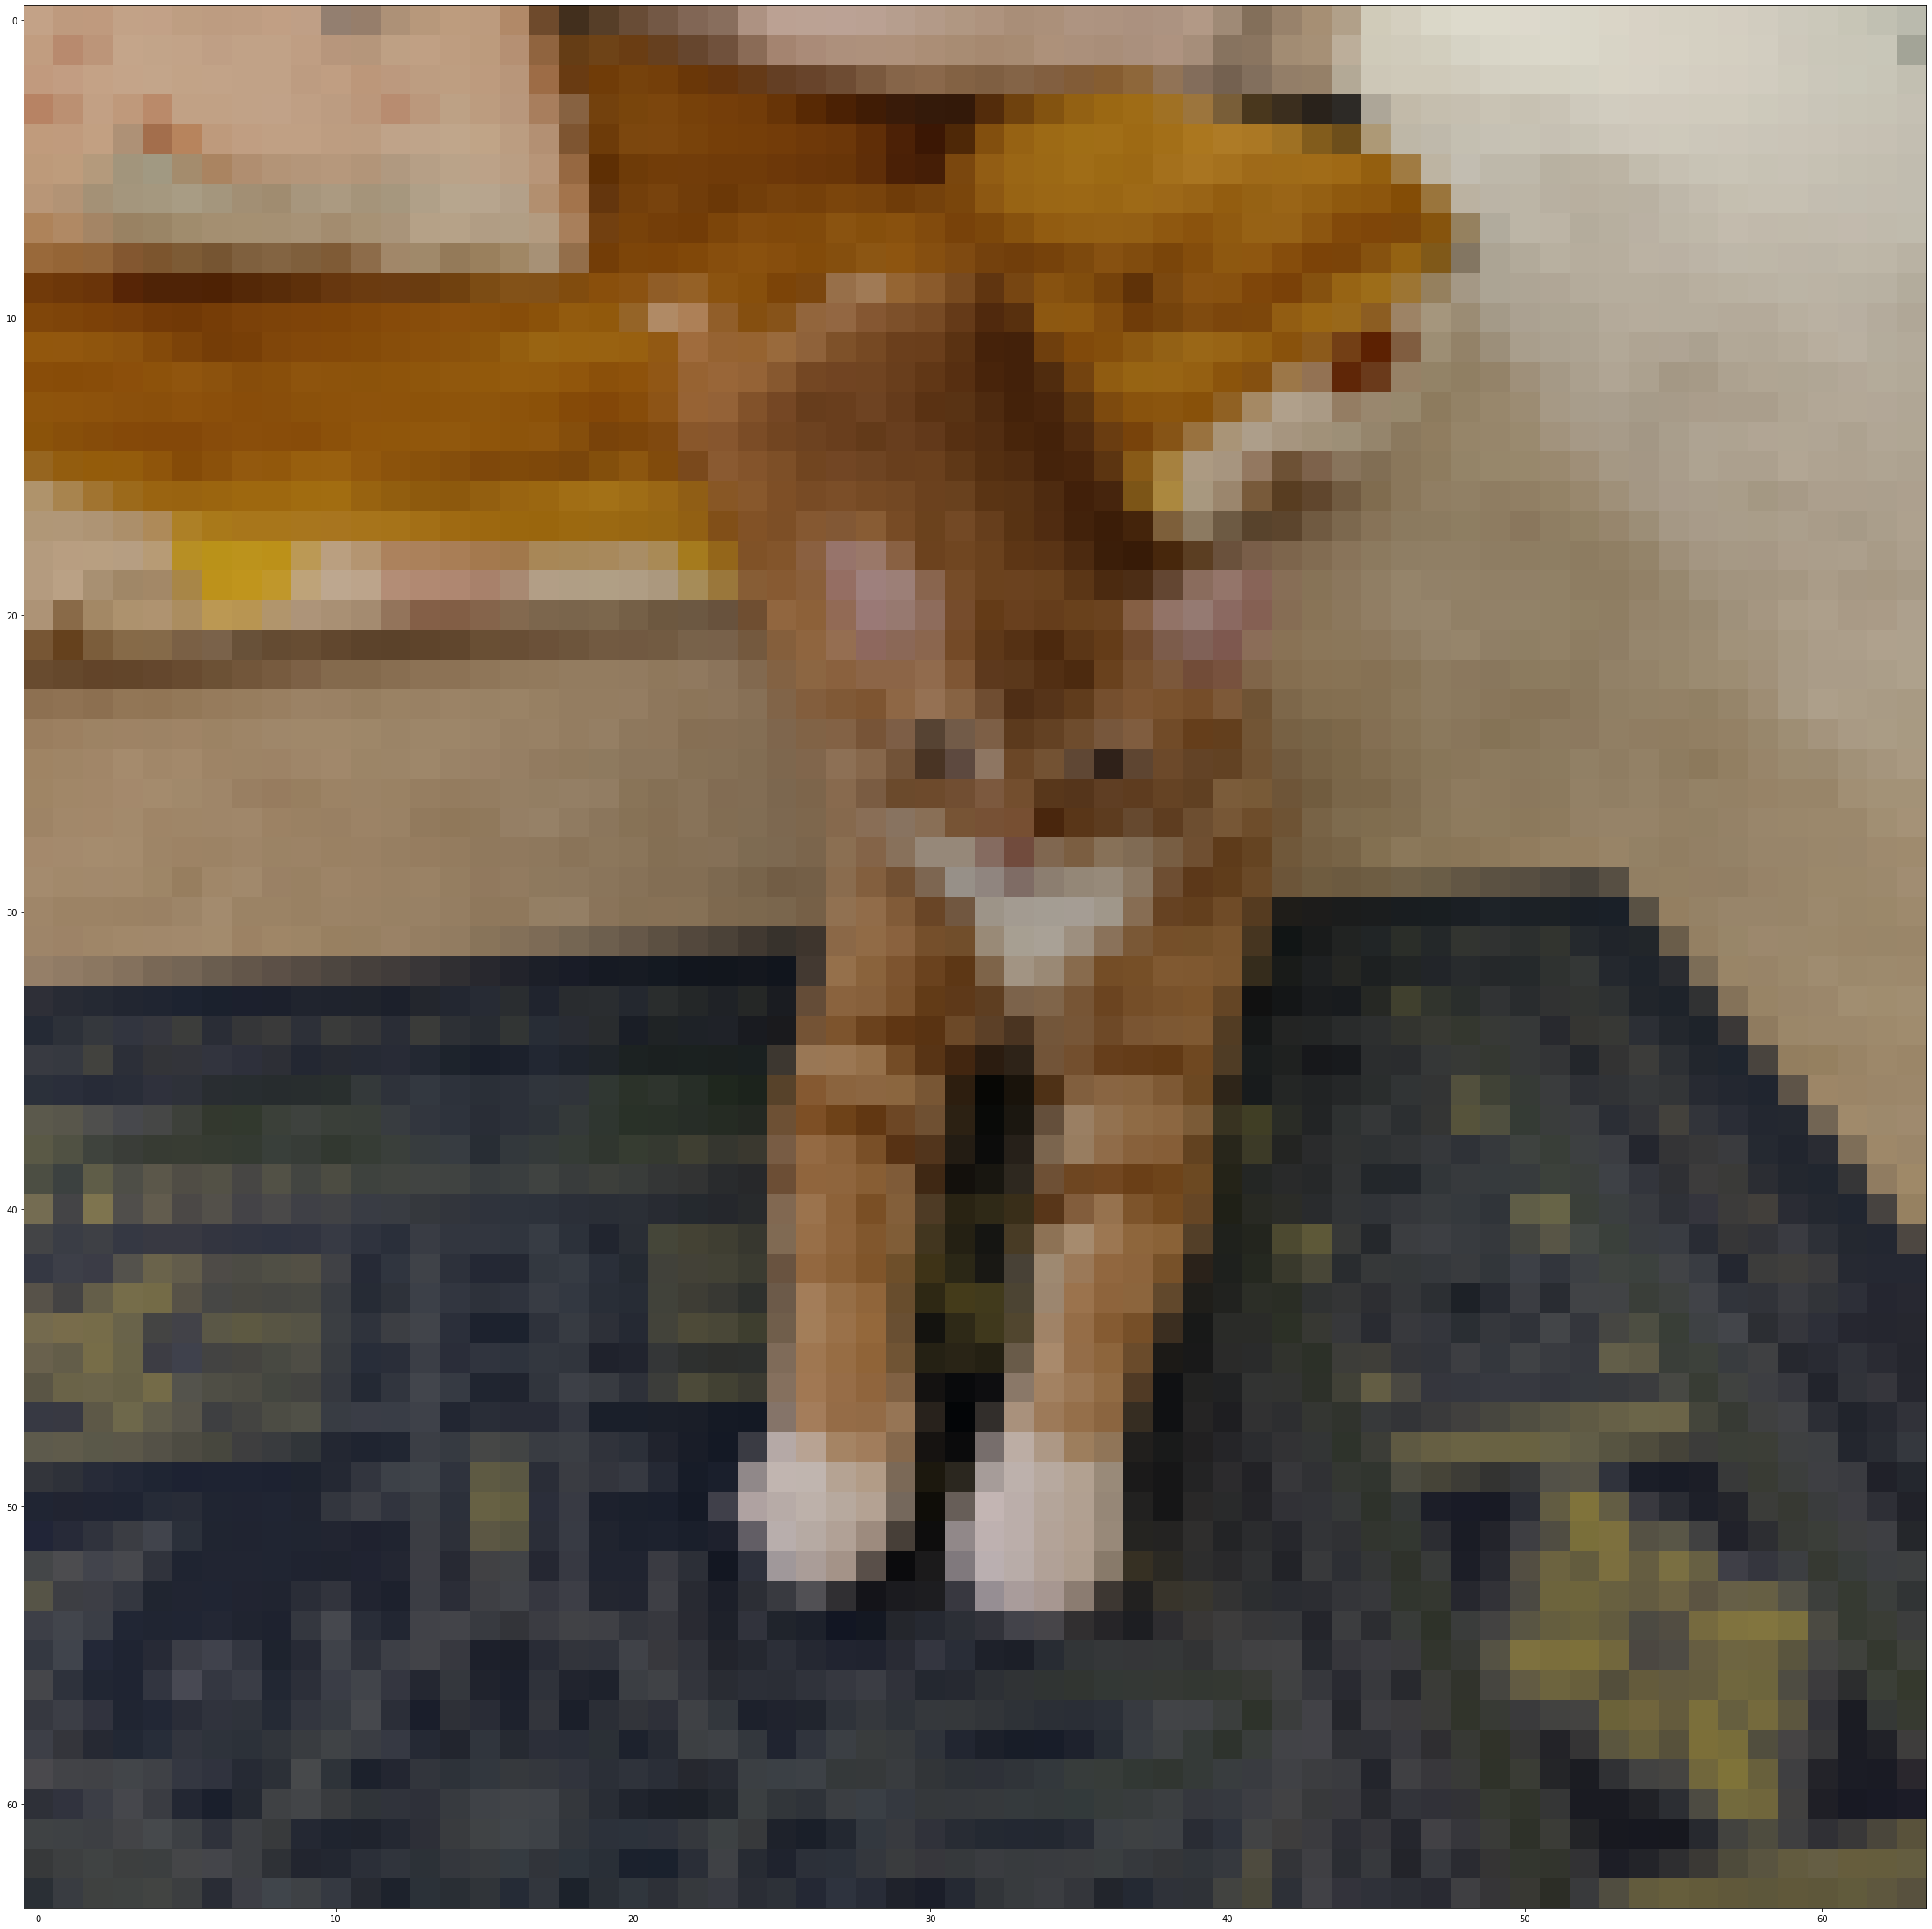

In [25]:
my_image = "cat_overflow.jpg" # change this to the name of your image file 
my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)

fname = "images/" + my_image
image = np.array(Image.open(fname).resize((num_px, num_px)))
plt.imshow(image)
image = image / 255.
image = image.reshape((1, num_px * num_px * 3)).T

my_predicted_image = predict(image, my_label_y, parameters)

print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

Accuracy: 0.0
y = 0.0, your L-layer model predicts a "non-cat" picture.


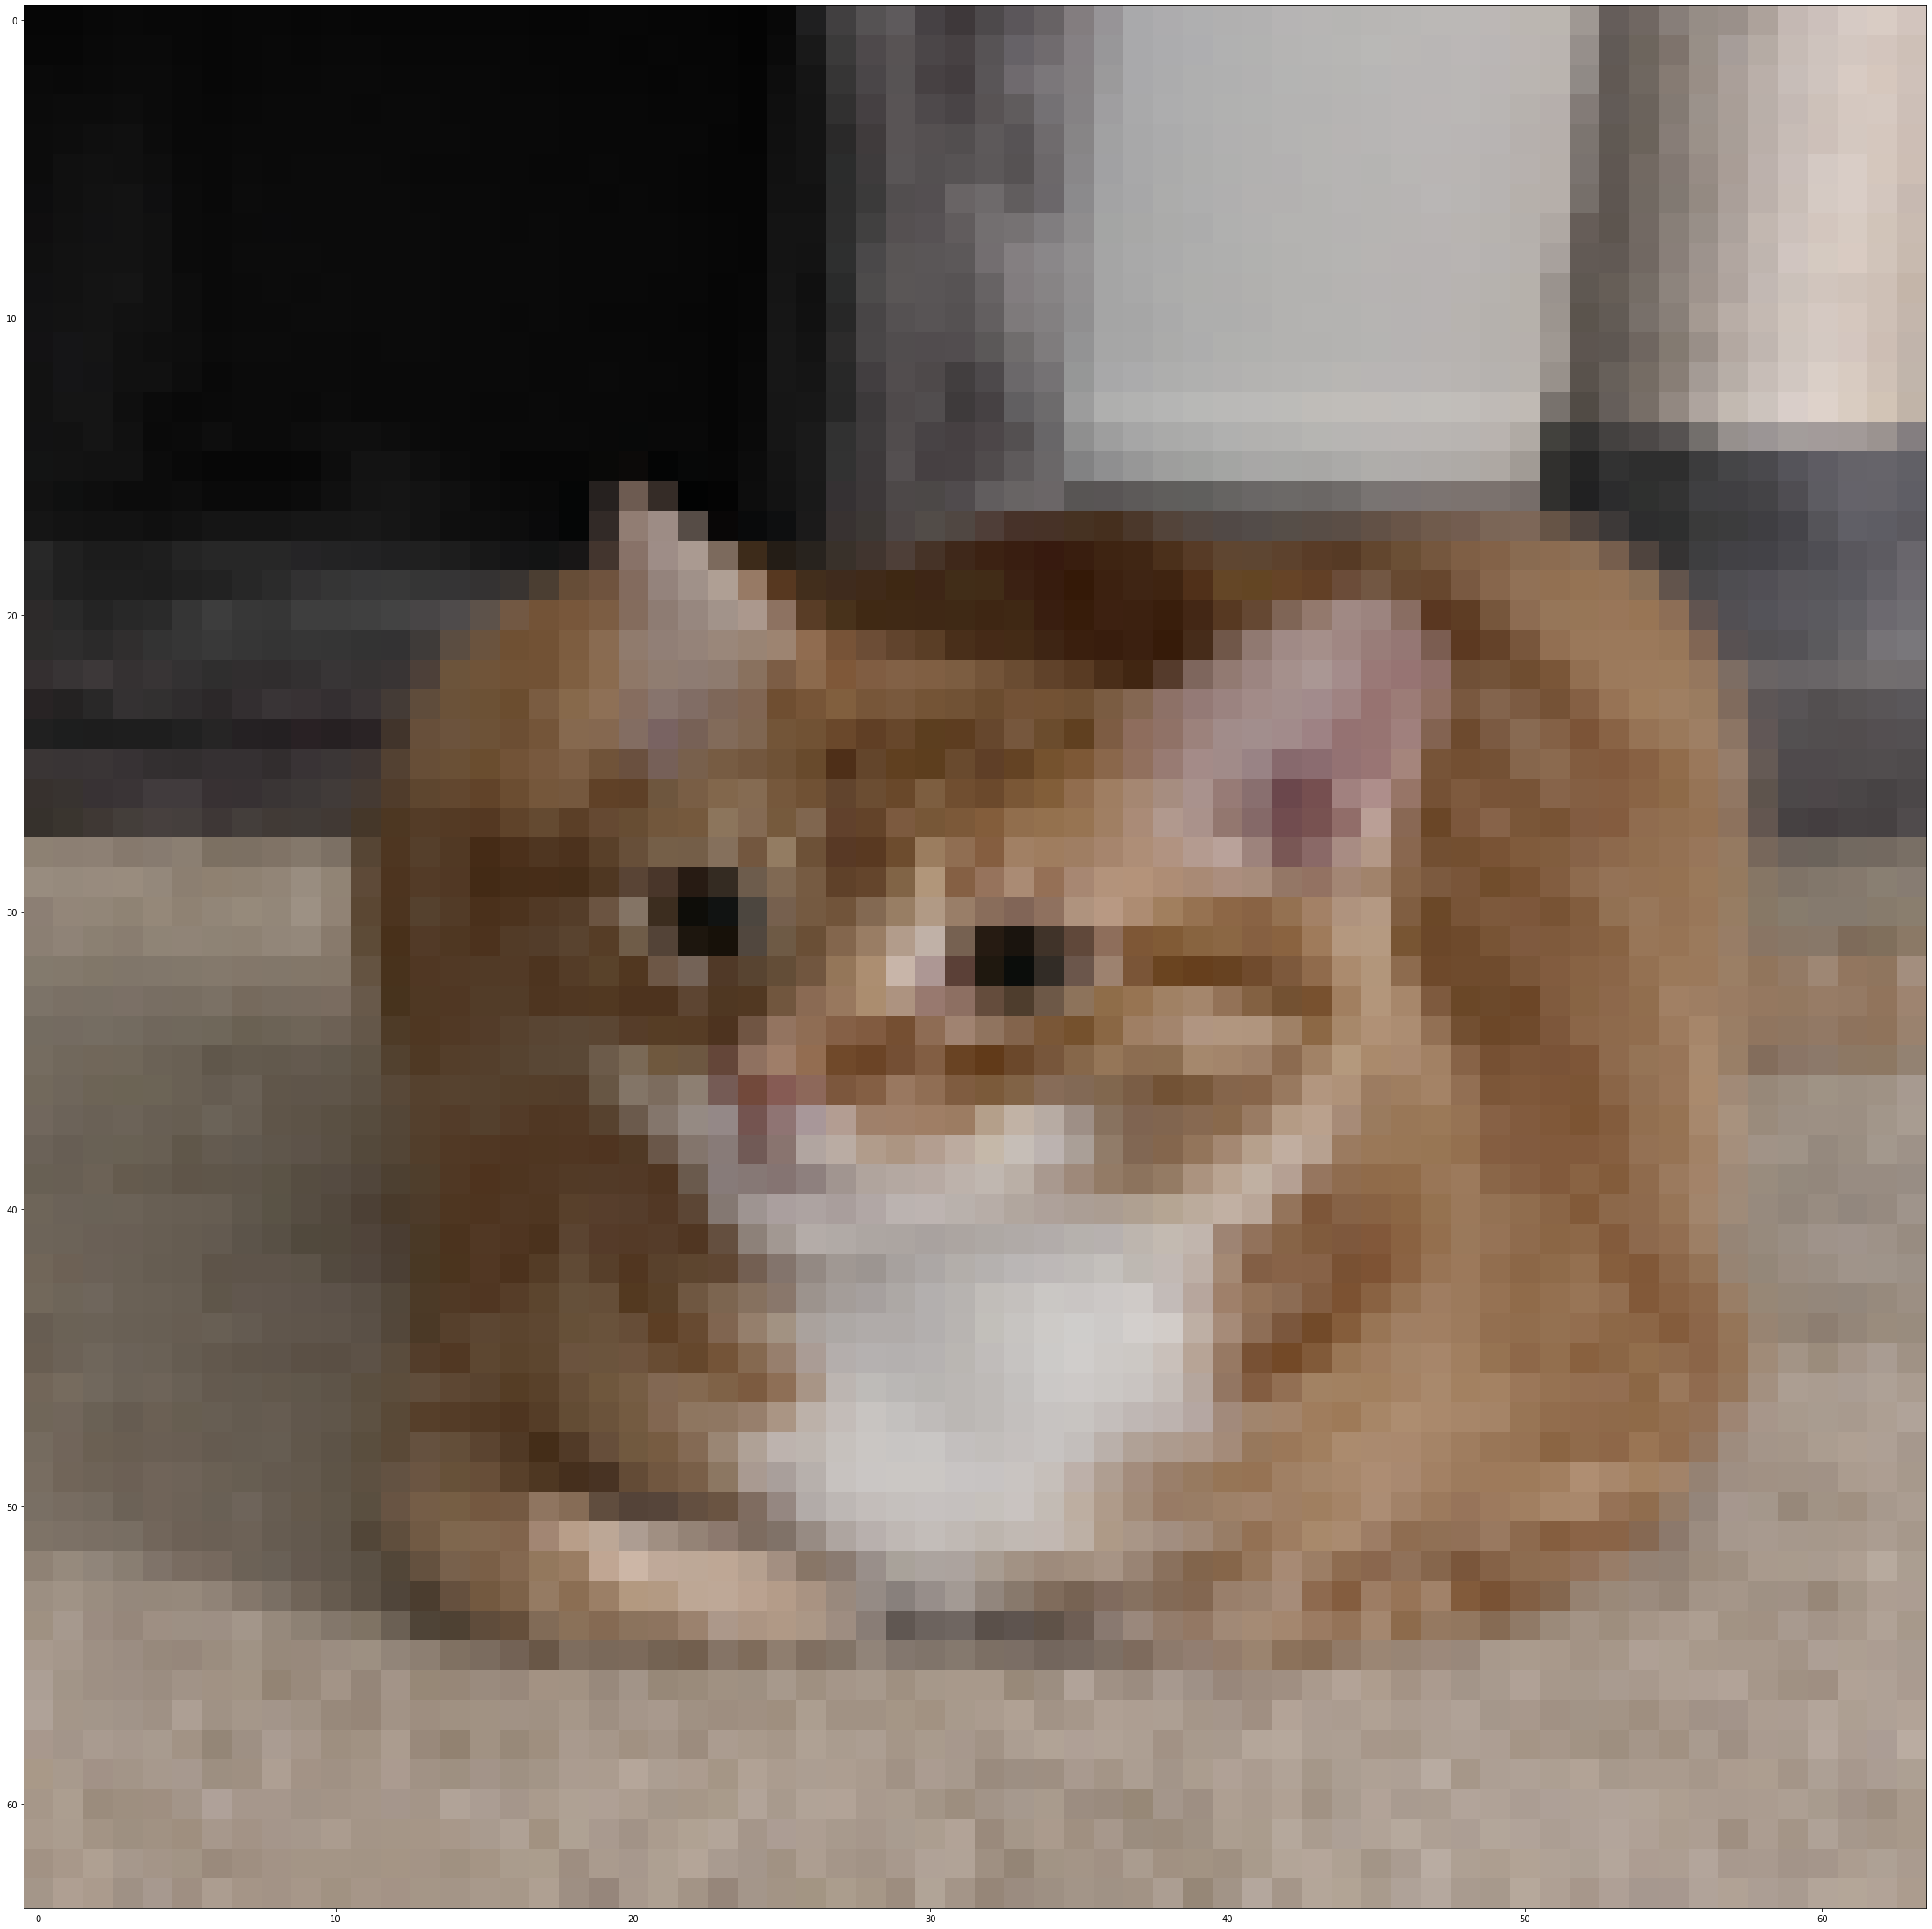

In [26]:
my_image = "cat_loaf.jpg" # change this to the name of your image file 
my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)

fname = "images/" + my_image
image = np.array(Image.open(fname).resize((num_px, num_px)))
plt.imshow(image)
image = image / 255.
image = image.reshape((1, num_px * num_px * 3)).T

my_predicted_image = predict(image, my_label_y, parameters)

print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

Apparently this classifier doesn't work very well...